In [19]:
import sys
sys.path.append('/home/bolocam/erapaport/Spectro_Imaging_Forecasting_Tool/')
import SIFT_classes as SIFT
import projections as proj
import numpy as np
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
c = 299792458.0                                         # Speed of light - [c] = m/s
h_p = 6.626068e-34                                      # Planck's constant in SI units
k_b = 1.38065e-23                                       # Boltzmann constant in SI units
MJyperSrtoSI = 1e-20                                    # MegaJansky/Sr to SI units
GHztoHz = 1e9                                           # Gigahertz to hertz
HztoGHz = 1e-9                                          # Hertz to Gigahertz
TCMB = 2.725                                            # Canonical CMB in Kelvin
m = 9.109*10**(-31)                                     # Electron mass in kgs

In [3]:
# Pixels per band
# 11335 channel case
pix1 = 150
pix2 = 250
pix3 = 1000
pix4 = 1250
pix5 = 750

# Band resolutions
# Hybrid 3-3-5 First choice
# Band resolutions for SOFTS
res1 = 17
res2 = 39
res3 = 26
res4 = 27
res5 = 100

Bands_list1 = [{'name':'Band 1','nu_meanGHz':145,'rms':0.36,'type':'OLIMPO'},\
      {'name':'Band 2','nu_meanGHz':250,'rms':0.36,'type':'OLIMPO'},\
      {'name':'Band 3','nu_meanGHz':365,'FBW':0.18,'nu_resGHz':res3,'N_pixels':pix3,'type':'spectrometric'},\
      {'name':'Band 4','nu_meanGHz':460,'FBW':0.15,'nu_resGHz':res4,'N_pixels':pix4,'type':'spectrometric'},\
      {'name':'Band 5','nu_meanGHz':660,'FBW':0.166,'nu_resGHz':res5,'N_pixels':pix5,'type':'spectrometric'}]

#Time = 86400 #1 day
#Time = 604800 #1 week
#Time = 3600.0  #1 hour
#Time = 3.154E7 # 1 year
time = 288000 #80 hours
#Time = 72000 #20 hours

In [4]:
#Galaxy cluster parameters
y = 1.5e-5
electron_temperature = 5.0 #KeV
peculiar_vel = 0.000001 #km/s
betac = peculiar_vel/(3e5)
Time = 288000 #80 hours

/home/bolocam/erapaport/Spectro_Imaging_Forecasting_Tool/SIFT_classes.py:145: RuntimeWarning: divide by zero encountered in log
  f = interp1d(np.log(datax),np.log(datay),kind='slinear',bounds_error=False,fill_value=0)


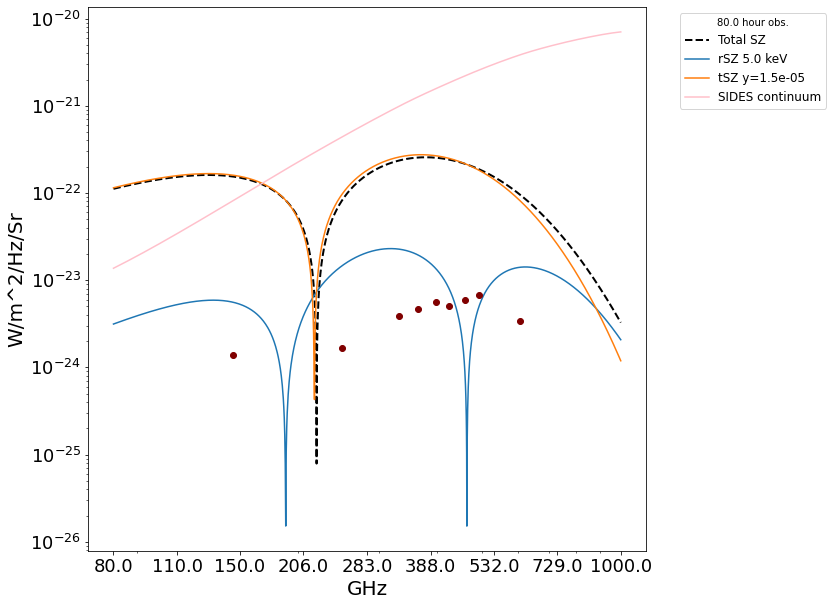

In [5]:
long = 120
lat = 120
proj.Differential_Intensity_Projection(y, electron_temperature, peculiar_vel,long,lat, Bands_list1, Time)

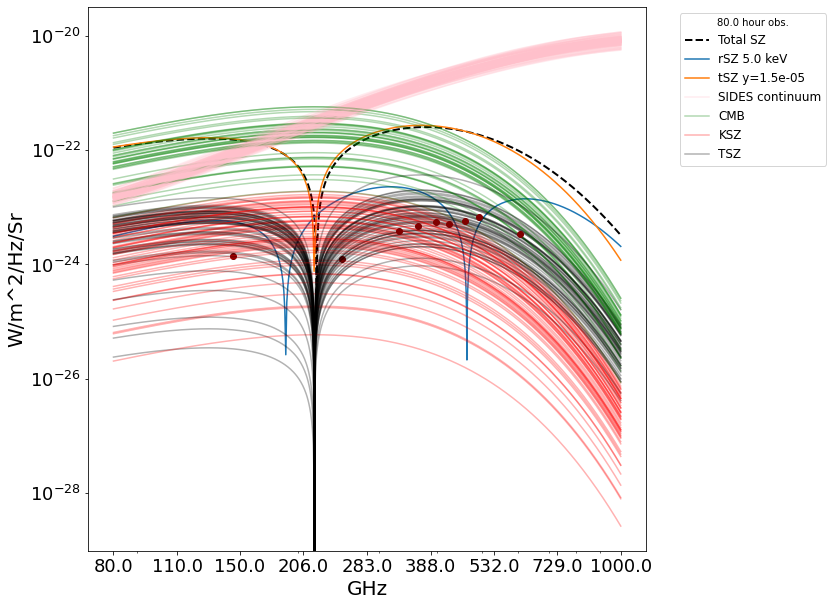

In [21]:
labels = ('tau','temperature','peculiar_velocity','amp_sides','b_sides')
#freq = np.linspace(80e9,720e9,1000)
freq = np.linspace(80e9,1000e9,1000)
sz_template = SIFT.szpack_signal(freq, SIFT.y_to_tau(y, electron_temperature), electron_temperature, peculiar_vel)
  
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
fig = plt.figure(figsize=(10,10))
  
#Plot SZ components
plt.plot(freq*HztoGHz,abs(sz_template),'--k',label='Total SZ',linewidth=2)
plt.plot(freq*HztoGHz,abs(SIFT.szpack_signal(freq,SIFT.y_to_tau(y,electron_temperature),electron_temperature,1e-11) - SIFT.classical_tsz(y,freq)),label='rSZ ' + str(electron_temperature) + ' keV')
        
plt.plot(freq*HztoGHz,abs(SIFT.classical_tsz(y,freq)),label='tSZ y=' + str(y))

#Read saved parameters file
df = pd.read_csv('/data/bolocam/bolocam/erapaport/Auxiliary/parameter_file_100',header=None) 
params = df.to_numpy()

for i in range(100):
    sides_long = int(params[i,0])
    sides_lat = int(params[i,1])
    amp_cmb = params[i,2]
    amp_ksz = params[i,3]
    amp_tsz= params[i,4]
    
    #SIDES continuum model and emission line data
    sides_template = SIFT.SIDES_continuum(freq, sides_long, sides_lat)
    plt.plot(freq*HztoGHz,abs(sides_template),color='pink',alpha=0.3,label='SIDES continuum')
    
    plt.plot(freq*HztoGHz,SIFT.dB(amp_cmb, freq),color='green',alpha=0.3,label='CMB')
    plt.plot(freq*HztoGHz,SIFT.dB(amp_ksz, freq),color='red',alpha=0.3,label='KSZ')
    plt.plot(freq*HztoGHz,SIFT.classical_tsz(amp_tsz, freq),color='black',alpha=0.3,label='TSZ')
    
            
bands = Bands_list1    
rms_values = np.asarray([0.36, 0.27])*(np.sqrt(80)/(np.sqrt(time/3600)))
frequencies = [145,250]
nu_total_array = np.array(frequencies)*GHztoHz
x = h_p*nu_total_array/(k_b*TCMB)
sigma_b_array = 2*k_b*((nu_total_array/c)**2)*(x/(np.exp(x)-1))*(x*np.exp(x))/(np.exp(x)-1)*np.array(rms_values)*1e-6
plt.scatter(nu_total_array*HztoGHz,sigma_b_array, color='maroon')
ncolor = len(bands)-2
color=iter(cm.gray_r(np.linspace(1,0.8,ncolor+1)))
for bb in range(ncolor):
    b1 = bands[bb+2]
    nu_vec_b1, sigma_B_b1 = SIFT.sigB(b1, time)

    colr=next(color)
    plt.plot(nu_vec_b1*HztoGHz, sigma_B_b1,'o', lw=7, alpha=1, color='maroon')
            
            
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GHz',fontsize=20)
plt.ylabel('W/m^2/Hz/Sr',fontsize=20)

#Make xticks match as best as possible
plt.xticks(np.rint(np.logspace(np.log10(80), np.log10(1e3),num=9)),np.rint(np.logspace(np.log10(80), np.log10(1e3),num=9)))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, prop={'size':12}, ncol=1, title= '{} hour obs.'.format(time/3600))
plt.show()

In [25]:
print(sides_template[782])

6.13151506447123e-21


In [ ]:
9.454835208279321e-21*x=6.13151506447123e-21


In [27]:
sides_template = SIFT.SIDES_continuum(freq, 31, 54)
sides_template = sides_template*((6.13151506447123e-21)/sides_template[782])
print(sides_template[782])

6.13151506447123e-21


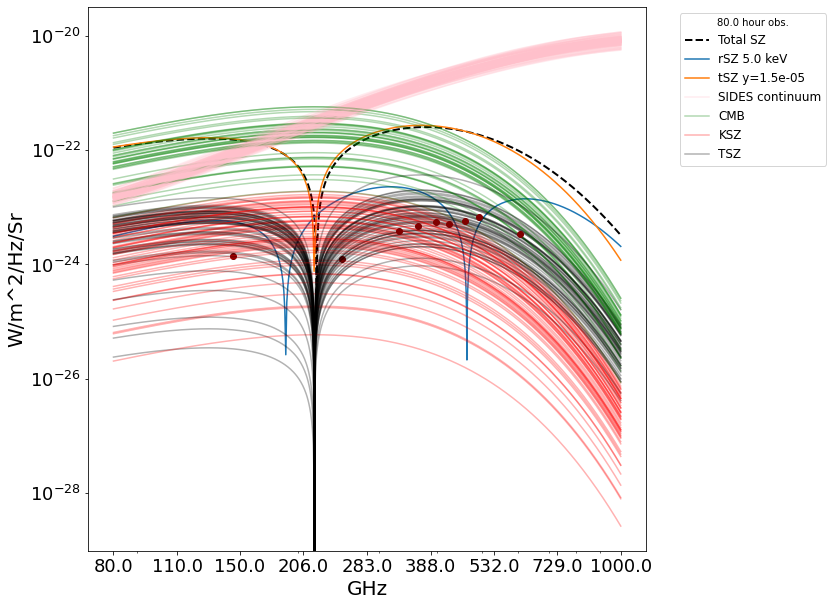

In [23]:
labels = ('tau','temperature','peculiar_velocity','amp_sides','b_sides')
#freq = np.linspace(80e9,720e9,1000)
freq = np.linspace(80e9,1000e9,1000)
sz_template = SIFT.szpack_signal(freq, SIFT.y_to_tau(y, electron_temperature), electron_temperature, peculiar_vel)
  
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
fig = plt.figure(figsize=(10,10))
  
#Plot SZ components
plt.plot(freq*HztoGHz,abs(sz_template),'--k',label='Total SZ',linewidth=2)
plt.plot(freq*HztoGHz,abs(SIFT.szpack_signal(freq,SIFT.y_to_tau(y,electron_temperature),electron_temperature,1e-11) - SIFT.classical_tsz(y,freq)),label='rSZ ' + str(electron_temperature) + ' keV')
        
plt.plot(freq*HztoGHz,abs(SIFT.classical_tsz(y,freq)),label='tSZ y=' + str(y))

#Read saved parameters file
df = pd.read_csv('/data/bolocam/bolocam/erapaport/Auxiliary/parameter_file_100',header=None) 
params = df.to_numpy()

for i in range(100):
    sides_long = int(params[i,0])
    sides_lat = int(params[i,1])
    amp_cmb = params[i,2]
    amp_ksz = params[i,3]
    amp_tsz= params[i,4]
    
    #SIDES continuum model and emission line data
    sides_template = SIFT.SIDES_continuum(freq, sides_long, sides_lat)
    plt.plot(freq*HztoGHz,abs(sides_template),color='pink',alpha=0.3,label='SIDES continuum')
    
    plt.plot(freq*HztoGHz,SIFT.dB(amp_cmb, freq),color='green',alpha=0.3,label='CMB')
    plt.plot(freq*HztoGHz,SIFT.dB(amp_ksz, freq),color='red',alpha=0.3,label='KSZ')
    plt.plot(freq*HztoGHz,SIFT.classical_tsz(amp_tsz, freq),color='black',alpha=0.3,label='TSZ')
            
bands = Bands_list1    
rms_values = np.asarray([0.36, 0.27])*(np.sqrt(80)/(np.sqrt(time/3600)))
frequencies = [145,250]
nu_total_array = np.array(frequencies)*GHztoHz
x = h_p*nu_total_array/(k_b*TCMB)
sigma_b_array = 2*k_b*((nu_total_array/c)**2)*(x/(np.exp(x)-1))*(x*np.exp(x))/(np.exp(x)-1)*np.array(rms_values)*1e-6
plt.scatter(nu_total_array*HztoGHz,sigma_b_array, color='maroon')
ncolor = len(bands)-2
color=iter(cm.gray_r(np.linspace(1,0.8,ncolor+1)))
for bb in range(ncolor):
    b1 = bands[bb+2]
    nu_vec_b1, sigma_B_b1 = SIFT.sigB(b1, time)

    colr=next(color)
    plt.plot(nu_vec_b1*HztoGHz, sigma_B_b1,'o', lw=7, alpha=1, color='maroon')
            
            
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GHz',fontsize=20)
plt.ylabel('W/m^2/Hz/Sr',fontsize=20)

#Make xticks match as best as possible
plt.xticks(np.rint(np.logspace(np.log10(80), np.log10(1e3),num=9)),np.rint(np.logspace(np.log10(80), np.log10(1e3),num=9)))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, prop={'size':12}, ncol=1, title= '{} hour obs.'.format(time/3600))
plt.show()